## Import Libraries

In [251]:
!pip install googlemaps
!pip install geopandas
!pip3 install geopy

In [252]:
import pandas as pd
import numpy as np
import geopandas 
from googlemaps import Client as GoogleMaps
import geopy.distance

## Download datasets:

### Read trips dataset

In [253]:
df_trips = pd.read_csv("data/trip_data.csv")
df_trips.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'fare_amount', 'tip_amount', 'total_amount'],
      dtype='object')

#### As it was stated that trips during lunchtime (11:30 am - 2 pm) and dinnertime (5 pm - 9 pm) were to restaurants. Let us consider only those datapoints as trips data.

In [254]:

df_trips_timed = df_t[((df_t.tpep_dropoff_datetime.str.split(" ",expand=True)[1] > '11:30:00') & 
                       (df_t.tpep_dropoff_datetime.str.split(" ",expand=True)[1] < '14:00:00')) | 
                      ((df_t.tpep_dropoff_datetime.str.split(" ",expand=True)[1] > '17:00:00') & 
                       (df_t.tpep_dropoff_datetime.str.split(" ",expand=True)[1] < '21:00:00'))]

print(len(df_trips_timed))

df_trips_timed = df_trips_timed.reset_index(drop=True)
# df_trips_timed consists of only trips during lunchtime and dinnertime. 
df_trips_timed.head()

33471


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05
1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00 +00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68
2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00 +00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30
3,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:28:18 +00:00,5,8.33,-73.863060,40.769581,-73.952713,40.785782,26.0,8.08,41.21
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36 +00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30


### Reading resturants dataset

In [3]:
# google geocoding api key to convert address of a resturant to latitude and longitude. 
gmaps = GoogleMaps('paste google api key here')

In [260]:
# read data 
df_r = pd.read_csv("data/restaurant_data.csv")
df_r.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],
      dtype='object')

In [261]:
# we dont want NaN values primarily in ['BUILDING', 'STREET', 'ZIPCODE', 'CAMIS', 'DBA','BORO', 'CUISINE DESCRIPTION', 'CRITICAL FLAG'] columns 
# as later these are used for modeling.
df_r_unique = df_r.dropna()
df_r_unique = df_r_unique.reset_index()


In [262]:
len(df_r_unique)

191636

In [263]:
# concatenating 'Building', 'street' and 'zipcode' to get complete address of resturant.
# This is reuqired to find latitude and longitude using google geocoding api. 

df_r_unique['ADDRESS'] = ''
for i in range(len(df_r_unique)):
    df_r_unique['ADDRESS'][i] = df_r_unique['BUILDING'][i] + ' ' + df_r_unique['STREET'][i] + ' ' + str(int(df_r_unique['ZIPCODE'][i]))
    


/var/folders/dz/k6x51lvd2jv050r966v_h2br0000gn/T/ipykernel_19884/117765336.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_r_unique['ADDRESS'][i] = df_r_unique['BUILDING'][i] + ' ' + df_r_unique['STREET'][i] + ' ' + str(int(df_r_unique['ZIPCODE'][i]))


In [265]:
# in order to join the above two datasets we only require unique addresses and their location.
df_r_unique = df_r_unique.drop_duplicates(subset=['ADDRESS'], keep='last')
df_r_unique.reset_index(inplace = True)
len(df_r_unique)

22489

In [266]:
df_r_unique['LONG_GCP'] = ""
df_r_unique['LAT_GCP'] = ""

In [287]:

for x in range(len(df_r_unique)):
    try:
        geocode_result = gmaps.geocode(df_r_unique['ADDRESS'][x])
        df_r_unique['LAT_GCP'][x] = geocode_result[0]['geometry']['location'] ['lat']
        df_r_unique['LONG_GCP'][x] = geocode_result[0]['geometry']['location']['lng']
    except IndexError:
        print("Address was wrong...")
    except Exception as e:
        print("Unexpected error occurred.", e )
    

In [268]:
# lets remove rows whose address couldn't be converted into latitude and longitude as the address is either not 
# properly clear or is not found.
df_r_unique2 = df_r_unique[(df_r_unique['LONG_GCP'] != "") | (df_r_unique['LAT_GCP'] != "")].copy(deep=True)
len(df_r_unique2)

22489

#### Converting trip and resturant dataframes into GeoDataframe using Latitude and Longitude. This is done to join both dataframes on geometry column based on closest proximity

In [270]:
df_r_unique2.dropna(subset=['LONG_GCP','LAT_GCP'], inplace = True)
df_r_unique2.reset_index(drop=True, inplace = True)

## Link the two datasets spatially

#### The two geodataframes are joined based on the haversine formula, which assumes the earth is a sphere, which results in errors of up to about 0.5% (according to help(geopy.distance)) 

In [276]:
# convert trip dataframe to geodataframe
gdf_trips = geopandas.GeoDataFrame(
    df_t_timed, geometry=geopandas.points_from_xy(df_t_timed.dropoff_longitude, df_t_timed.dropoff_latitude))

# convert resturant dataframe to geodataframe
gdf_resturants = geopandas.GeoDataFrame(
    df_r_unique2, geometry=geopandas.points_from_xy(df_r_unique3.LONG_GCP, df_r_unique3.LAT_GCP))

# join both geodataframes using proximity distance of 50 meters based on geometry column
gdf_combined = gdf_trips.sjoin_nearest(gdf_resturants, how='inner', max_distance=50)

gdf_combined.reset_index(drop=True, inplace = True)

gdf_combined

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,...,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,ADDRESS,LONG_GCP,LAT_GCP
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,...,Non-food contact surface improperly constructe...,Not Critical,4.0,A,05/22/2015,08/28/2017,Cycle Inspection / Initial Inspection,639 3 AVENUE 10017,-73.974588,40.750183
1,2,2015-01-15 14:00:57 +00:00,2015-01-16 13:47:27 +00:00,1,0.95,-73.990692,40.755806,-73.974998,40.750580,7.0,...,Non-food contact surface improperly constructe...,Not Critical,4.0,A,05/22/2015,08/28/2017,Cycle Inspection / Initial Inspection,639 3 AVENUE 10017,-73.974588,40.750183
2,1,2015-01-15 12:09:49 +00:00,2015-01-15 12:20:50 +00:00,2,1.10,-73.975876,40.761192,-73.974884,40.750137,8.0,...,Non-food contact surface improperly constructe...,Not Critical,4.0,A,05/22/2015,08/28/2017,Cycle Inspection / Initial Inspection,639 3 AVENUE 10017,-73.974588,40.750183
3,2,2015-01-15 17:11:55 +00:00,2015-01-15 17:29:33 +00:00,1,1.53,-73.987465,40.732830,-73.974648,40.750359,12.0,...,Non-food contact surface improperly constructe...,Not Critical,4.0,A,05/22/2015,08/28/2017,Cycle Inspection / Initial Inspection,639 3 AVENUE 10017,-73.974588,40.750183
4,2,2015-01-15 16:38:41 +00:00,2015-01-15 17:40:45 +00:00,1,17.05,-73.782112,40.644650,-73.974907,40.750568,52.0,...,Non-food contact surface improperly constructe...,Not Critical,4.0,A,05/22/2015,08/28/2017,Cycle Inspection / Initial Inspection,639 3 AVENUE 10017,-73.974588,40.750183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38832,1,2015-01-15 20:05:57 +00:00,2015-01-15 20:11:00 +00:00,1,1.20,-73.995666,40.724792,-74.007347,40.711456,6.0,...,Cold food item held above 41Âº F (smoked fish ...,Critical,12.0,A,11/02/2016,08/28/2017,Pre-permit (Operational) / Initial Inspection,5 BEEKMAN ST 10038,-74.006828,40.711430
38833,1,2015-01-15 20:05:58 +00:00,2015-01-15 20:12:40 +00:00,1,1.50,-73.982323,40.767231,-73.972862,40.785934,7.5,...,Food not cooled by an approved method whereby ...,Critical,42.0,C,02/24/2016,08/28/2017,Cycle Inspection / Re-inspection,520 COLUMBUS AVENUE 10024,-73.972774,40.785987
38834,1,2015-01-15 20:16:20 +00:00,2015-01-15 20:49:15 +00:00,2,5.30,-73.957726,40.773052,-74.001648,40.718407,22.5,...,Food not protected from potential source of co...,Critical,56.0,Z,08/10/2017,08/28/2017,Cycle Inspection / Re-inspection,266 CANAL ST 10013,-74.001242,40.718659
38835,1,2015-01-15 20:16:21 +00:00,2015-01-15 20:36:12 +00:00,2,11.50,-73.872993,40.774178,-74.004105,40.720997,32.0,...,Non-food contact surface improperly constructe...,Not Critical,12.0,A,04/24/2017,08/28/2017,Cycle Inspection / Re-inspection,374 CANAL STREET 10013,-74.004427,40.720905


## Creating an exploratory map

### The blue dots show the pick location where as the yellow dots show the resturant location with the type of cuisine they serve.
<img src = "kepler-visualization.jpg" style="width:700px; height:600px"/>

## Exploratory data analysis questions

### How far do people travel based on different types of cuisine?

In [278]:
len(gdf_combined['CUISINE DESCRIPTION'].unique())

82

In [279]:
gdf_combined['DISTANCE_TRAVELLED'] = ""

for x in range(len(gdf_combined)):
    try:
        coords_1 = (gdf_combined['pickup_latitude'][x], gdf_combined['pickup_longitude'][x])
        coords_2 = (gdf_combined['LAT_GCP'][x], gdf_combined['LONG_GCP'][x])
        gdf_combined['DISTANCE_TRAVELLED'][x] = geopy.distance.geodesic(coords_1, coords_2).miles
    except IndexError:
        print("IndexError", geopy.distance.geodesic(coords_1, coords_2).miles)
    except Exception as e:
        print("Unexpected error occurred.", e) 

/var/folders/dz/k6x51lvd2jv050r966v_h2br0000gn/T/ipykernel_19884/2050848742.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_combined['DISTANCE_TRAVELLED'][x] = geopy.distance.geodesic(coords_1, coords_2).miles


In [281]:
gdf_combined.sort_values("DISTANCE_TRAVELLED", ascending=False)['DISTANCE_TRAVELLED']
# we found an extreme outlier in the data, this should be removed. 

8329     346.794997
34171     20.156912
33283     19.632348
33282     19.632348
26341     19.478686
            ...    
36028      0.003003
36027      0.003003
20648      0.002821
20647      0.002821
7713       0.002611
Name: DISTANCE_TRAVELLED, Length: 38837, dtype: object

In [282]:
gdf_combined = gdf_combined[gdf_combined['DISTANCE_TRAVELLED'] != gdf_combined['DISTANCE_TRAVELLED'].max()]
gdf_combined.reset_index(inplace = True)

In [283]:
gdf_combined.sort_values("DISTANCE_TRAVELLED", ascending=False)['DISTANCE_TRAVELLED']

34170    20.156912
33281    19.632348
33282    19.632348
26340    19.478686
38296    19.314463
           ...    
36026     0.003003
36027     0.003003
20647     0.002821
20646     0.002821
7713      0.002611
Name: DISTANCE_TRAVELLED, Length: 38836, dtype: object

#### Average distance travelled 

In [258]:
gdf_combined['DISTANCE_TRAVELLED'].mean()

1.9809642620689494

#### Standard deviatioon of distance travelled

In [259]:
gdf_combined['DISTANCE_TRAVELLED'].std()

2.350000290970313

#### Based on the mean and standard deviation 67% of the distance travelled are within 4.33 miles

In [242]:
# To answer - How far do people travel based on different types of cuisine?
graph_tmp_cusine = gdf_combined.groupby(['CUISINE DESCRIPTION'], as_index = False)['DISTANCE_TRAVELLED'].mean().copy(deep = True)


In [243]:
graph_tmp_cusine.columns

Index(['CUISINE DESCRIPTION', 'DISTANCE_TRAVELLED'], dtype='object')

<AxesSubplot:xlabel='CUISINE DESCRIPTION'>

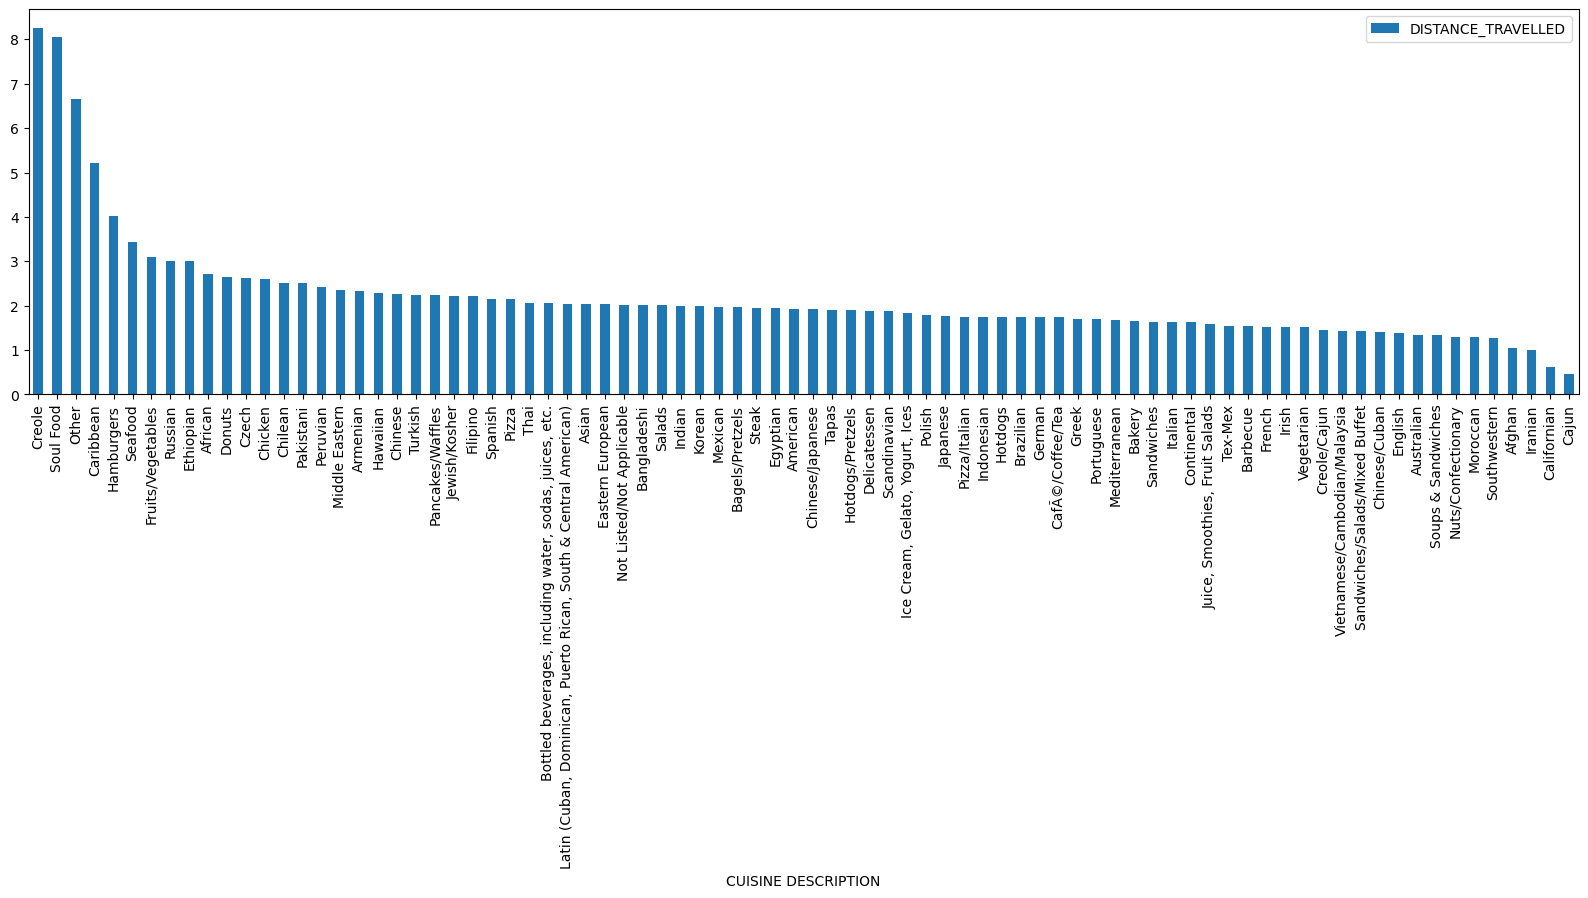

In [244]:
graph_tmp_cusine.sort_values("DISTANCE_TRAVELLED", ascending=False).plot.bar(x = 'CUISINE DESCRIPTION', y = 'DISTANCE_TRAVELLED', figsize=(20, 5))



In [285]:
graph_tmp_cusine.sort_values("DISTANCE_TRAVELLED", ascending=False)

,CUISINE DESCRIPTION,DISTANCE_TRAVELLED
22,Creole,8.262501
71,Soul Food,8.049429
57,Other,6.667293
15,Caribbean,5.205806
36,Hamburgers,4.027879
...,...,...
73,Southwestern,1.275113
0,Afghan,1.047403
43,Iranian,0.992074
14,Californian,0.623562


As seen from above graph - on an average the highest distance traveled is 8.262501 miles. But the acutal highest distance traveled is close to 20 miles. The bar graph shows the average distance travelled by people based on cuisine.

### How far do people travel based on the borough where the restaurant is located ?

In [245]:
graph_tmp_boro = gdf_combined.groupby(['BORO'], as_index = False)['DISTANCE_TRAVELLED'].mean()

<AxesSubplot:xlabel='BORO'>

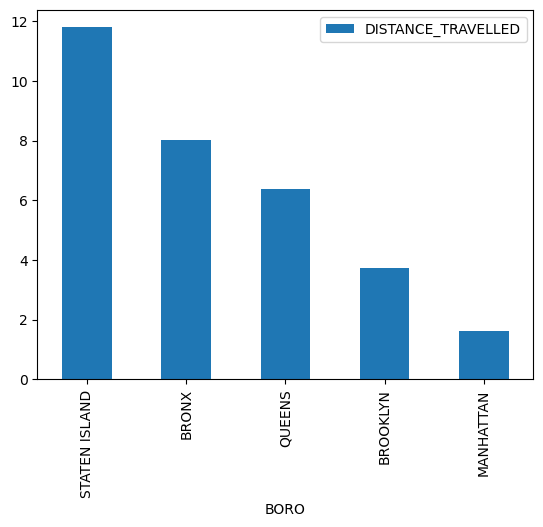

In [246]:
graph_tmp_boro.sort_values("DISTANCE_TRAVELLED", ascending=False).plot.bar(x = 'BORO', y = 'DISTANCE_TRAVELLED')

In [247]:
gdf_combined.groupby(['BORO'], as_index = False)['DISTANCE_TRAVELLED'].mean()

,BORO,DISTANCE_TRAVELLED
0,BRONX,8.032041
1,BROOKLYN,3.726855
2,MANHATTAN,1.640221
3,QUEENS,6.384624
4,STATEN ISLAND,11.799483


The Staten Island have more people travelling long distances on average. Then followed by Bronx. 

### How far do people travel based on meal time?

In [248]:
gdf_combined.groupby((gdf_combined.tpep_dropoff_datetime.str.split(" ",expand=True)[1] > '11:30:00') & (gdf_combined.tpep_dropoff_datetime.str.split(" ",expand=True)[1] < '14:00:00'))['DISTANCE_TRAVELLED'].mean()


1
False    2.075457
True     1.799271
Name: DISTANCE_TRAVELLED, dtype: float64

True - corresponds to Lunch time and False to Dinner. 

As per the above results, people travel long distances for dinner with respect to luch time. 

## Describe how you would set up a predictive model

### To set up a predictive model given the two datasets of trips and restuarants, we can follow the following steps:

1. Define the problem - also state the assumptions made
2. Gather data
3. Clean and preprocess the data
4. Split the data
5. Choose a model
6. Train the model
7. Evaluate the model
8. Adjust the model
9. Use the model

### Define the problem

The problem statement is to predict cuisine type to be visited by a taxi rider based on information avilable in trip and restaurant datasets. The final combined dataframe contains 33,405 rows. 

Not to forget that the data is collected on 01/15/2015 for trips and 2014 - 2017 records are present for restaurants. Also collected from 5 Borough's in USA. The final predictive model works well is prediction is made on data point drawn from this distribution. 



### Gather data

Collect the data you need to train your model. This may involve finding a dataset online, extracting data from a database, or collecting data using surveys or other means.

we can predict cuisine based on weather, price range of restaurant, pickup location, drop location, distance travelled, passenger count, restaurant name.

* `weather`: Given the drop time and location, we could fetch the weather information as a discrete variable from public APIs. One such API is the [OpenWeather](https://openweathermap.org/api)
* `restaurant name`: Given the drop-location, we can infer the closest restaurant around the 50m radius. Restaurant name indicates standard knowledge about cuisines. Google's [Places](https://developers.google.com/maps/documentation/places/web-service/search-nearby) API is the best fit for this task.
* `price range`: As the price range of a restaurant is a direct indicator of its primary cuisine, we fetch the price range of the restaurant from the same API.
* `locations`: The pickup and drop locations are mapped to the geohash using the geo-hasing libraries.
* `passenger count`: Passenger count indicates the number of people riding and visiting the restaurant.
* `distance travelled`: Distance tarvelled is discretized into three ordinaly categories which provides a more robust feature representation.

### Clean and preprocess the data

Several possible cleaning startegies help for a simple and faster training.

1. Removing the outliers for the distance travelled improves the feature value which can be done by a blox plot.
2. The restaurant names are standardised by lower casing and removing any special characters
3. Any samples contaning empty feature values are ommited.

### Split the data

I will split data into 70% for train, 15% for validation and 15% for test. As the data is not huge this split is considered. 

### Choose a model


Few models which I would try: 

Random Forest: As the features mentioned above which would be used for predictions does not necessarily have category type data in all we can random forest which is an ensemble model that uses multiple decision trees to make predictions. Random forests can handle large datasets with high dimensionality and are robust against overfitting. It works by creating a large number of decision trees and averaging their predictions to obtain a more accurate prediction.


Naive Bayes: Naive Bayes assumes that the predictors are independent, all features in our case are indenpendent of each other. 

Support Vector Machines (SVMs): They work well with high-dimensional datasets and can handle non-linear data.

Neural Networks: They can be used for classification problems and can handle complex relationships between variables. 

Neural networks require a large amount of data to train and can be prone to overfitting, but they are capable of achieving high accuracy.

### Selected Methodology
* I would first discretize the above mentioned features. For instance, the distance travelled could be categorised into three categories. The pickup and drop locations can be categorised by geo-hash.

* Each feature has its own micro-modeling process. The restaurant name is better processed by a character level encoding model. The goehash can be processed by a word2vec type model. All the micro-models produce an embedding which are then concatenated or processed using attention to give a final representation vector of the features.

* The final embedding is then passed on to a classification head to predict the cuisine type.


### Train the model

Once you've chosen a model, you'll need to train it using the training set. This involves tuning the hyperparameters to adjust the mode until it fits the data as closely as possible.

### Evaluate the model

We initially evaluate the model on validation dataset and tune the hyperparameters until we get better results, later the final evaluation is done on test set to check the performance. 

I will use F1 score metric as the classes are imbalanced. 

### Adjust the model

If the model isn't performing well, you may need to adjust it. This could involve trying different types of models, adjusting the parameters of the existing model, or modifying the data to make it more suitable for the model.

### Use the model

Once you're satisfied with the performance of the model, you can start using it to make predictions. 